In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import math
from scipy import linalg as la
from scipy import signal
from scipy import special as ss
device = torch.device("cpu")
print(f"The Device: {device}")

print(f"MPS enabled: {torch.backends.mps.is_available()}")

The Device: cpu
MPS enabled: False


### Hippo reimplemented

In [119]:
class HIPPO_LEGS(nn.Module):
    """Hippo class utilizing legs polynomial"""

    def __init__(self, N, gbt_alpha = 0.5, maxlength = 1024):
        super(HIPPO_LEGS, self).__init__()
        self.N = N
        self.gbt_alpha = gbt_alpha
        self.maxlength = maxlength
        
    def compute_A(self, n, k):
        '''
        Computes the values for the HiPPO A matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k  
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns. 
        
        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N
        
        Returns:
            Values (float):
            Individual values for the elements in the A matrix. 
        '''
        if n > k:
            val = np.sqrt(2 * n + 1, dtype = np.float32) * np.sqrt(2 * k + 1, dtype = np.float32)
        if n == k:
            val = n + 1 
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        '''
        Computes the values for the HiPPO B matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}
        
        Input:
            n (int):
                nth column of a square matrix of size N.
            
        Returns:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        val = np.sqrt(2 * n + 1, dtype = np.float32)
        return val

    def get_A_and_B(self, N):
        '''
        Creates the HiPPO A and B matrix given the size N along a single axis of 
        a square matrix.
        
        Input: 
            N (int):
            Size N of a square matrix along a single axis.
        
        Returns: 
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        '''
        A = np.zeros((self.N, self.N), dtype = np.float32)
        B = np.zeros((self.N, 1), dtype = np.float32)

        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n = n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n = n , k = k)

        return A  * -1, B
    
    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        '''
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them. 
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):
        
        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.
            
            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        '''
        I = np.eye(A.shape[0], dtype = np.float32)
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)
        EQA = np.linalg.lstsq(EQ13_p1, EQ13_p2, rcond = None)[0]
        EQB =  np.linalg.lstsq(EQ13_p1, (delta_t * B), rcond = None)[0]         
        return EQA, EQB
    
    def get_stacked_GBT(self):
        A, B = self.get_A_and_B(self.N)
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N), dtype=np.float32)
        GBTB_stacked = np.empty((self.maxlength, self.N, 1), dtype=np.float32)
        
        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A = A, B = B, t = t, gbt_alpha = self.gbt_alpha)
            GBTA_stacked[t-1] = GBTA
            GBTB_stacked[t-1] = GBTB
            
        return GBTA_stacked, GBTB_stacked
    
    def discrete_hippo_operator(self, A, B, inputs, c_t =  None):
        '''
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray):
                shape: (batch size, input length, N)
                the initial hidden state
            inputs (torch.tensor):
                shape: (batch size, maxlength)
                the input sequence
        Returns:
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        print("-------- Input ----------")
        batchsize = inputs.shape[0]
        L = inputs.shape[1]

        # Change input shape from (batch size, max length)
        # to (max length, batch size, max length)
        # note that max length can also be regarded as the length of the signal
        print("inputs shape", inputs.shape)
        inputs = torch.tensor(inputs)
        inputs = inputs.T.unsqueeze(-1).unsqueeze(-1)
        print("inputs.T.unsqueeze.unsqueeze shape", inputs.shape)

        lst = []
        
        if c_t is None:
            c_t = np.zeros((batchsize, 1, self.N), dtype = np.float32)
            print("c t zeroes shape", c_t.shape)
        
        switch = True
        for t, f_t in enumerate(inputs):
            
            c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()
            lst.append(c_t)
            if switch== True:
                ("----------F Linear:----------")
                print("part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()).shape)
                print("part2  shape:",  (np.squeeze(B[t], -1) * f_t.numpy()).shape)
                print("A stacked  shape:", (torch.tensor(A[t]).float()).shape)
                print("B stacked  shape:",  (np.squeeze(B[t], -1)).shape)
                print("input [f] shape:", f_t.shape)
                print("Coef  c t shape:", c_t.shape)
                switch = False 
        print("c t stacked shape:", np.stack(lst, axis = 0, dtype = np.float32).shape)
        return np.stack(lst, axis = 0, dtype = np.float32)
    
    def reconstruct(self, c, B):
        print("-------- Reconstruction ----------")
        vals = np.linspace(0.0, 1.0, self.maxlength)
        print("c shape:", c.shape)
        print("B shape:", B.shape)
        if len(c.shape) == 4:
            # c shape from: [maxlength, batchsize, 1, N_coeffs]
            # 1st move to: [batchsize, maxlength, 1, N_coeffs]
            # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
            c = np.moveaxis(c, 0, 1)
            print("c shape:", c.shape)
            c = np.moveaxis(c, 2, 3)
            print("c shape:", c.shape)
        
        eval_mat = (B * np.float32(ss.eval_legendre(np.expand_dims(np.arange(self.N, dtype = np.float32), -1), 2 * vals - 1))).T
        
        print("Eval mat shape:", eval_mat.shape)
        print("B  shape:", B .shape)
        recon = eval_mat @ np.float32(c)
        print("Recon a shape:", recon.shape)
        return recon
    
    def forward(self, inputs):
        # 1.Compute B, GBTA and GBTA matrices
        # B is needed in 3. for the reconstruction
        # GBTA and GBTA is needed for coefficents c
        _, B = self.get_A_and_B(N = self.N)
        GBTA, GBTB = self.get_stacked_GBT()
        # 2.Compute coefficents c
        c = self.discrete_hippo_operator(A = GBTA, B = GBTB, inputs = inputs, c_t = None)
        # 3. Compute reconstruction r
        r =  self.reconstruct(c = c, B = B)
        return c, r


### Hippo original

In [105]:
def transition(measure, N, **measure_args):
    # Laguerre (translated)
    if measure == 'lagt':
        b = measure_args.get('beta', 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Legendre (translated)
    elif measure == 'legt':
        Q = np.arange(N, dtype=np.float64)
        R = (2*Q + 1) ** .5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
        B = R[:, None]
        A = -A
    # Legendre (scaled)
    elif measure == 'legs':
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == 'fourier':
        freqs = np.arange(N//2)
        d = np.stack([np.zeros(N//2), freqs], axis=-1).reshape(-1)[1:]
        A = 2*np.pi*(-np.diag(d, 1) + np.diag(d, -1))
        B = np.zeros(N)
        B[0::2] = 2
        B[0] = 2**.5
        A = A - B[:, None] * B[None, :]
        # A = A - np.eye(N)
        B *= 2**.5
        B = B[:, None]

    return A, B

class HiPPOScale(nn.Module):
    """ Vanilla HiPPO-LegS model (scale invariant instead of time invariant) """
    def __init__(self, N, method='legs', max_length=1024, discretization='bilinear'):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        A, B = transition(method, N)
        B = B.squeeze(-1)
        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)
        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 'forward':
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 'backward':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, np.eye(N), lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 'bilinear':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, Bt, lower=True)
            else: # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                B_stacked[t - 1] = la.solve_triangular(A, A_stacked[t - 1] @ B - B, lower=True)
        self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        self.eval_matrix = torch.Tensor((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T  )

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        # batched input signal has shape [batchsize, maxlength]
        print("-------- Input ----------")
        L = inputs.shape[1]
        
        inputs = inputs.T
        print("inputs.T shape:", inputs.T.shape)
        inputs = inputs.unsqueeze(-1).unsqueeze(-1)
        print("inputs.T.unsqueeze.unsqueeze shape:", inputs.shape)
        u = torch.transpose(inputs, 0, -2)
        print("u torch transpose inputs 0 -2:", u.shape)
        u = u * self.B_stacked[:L]
        print("u mult Bstack[:L]:", u.shape)
        print("Bstack[:L].shape:", self.B_stacked[:L].shape)
        u = torch.transpose(u, 0, -2) # (length, ..., N)
        print("u torch transpose inputs 0 -2:", u.shape)
        
        if fast:
            result = unroll.variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        c = torch.zeros(inputs.shape[1], 1, (self.N)).to(inputs)
        print("c torch zeros shape:", c.shape)
        switch = True
        cs = []
        for t, f in enumerate(inputs):
            # c = F.linear(c, self.A_stacked[t]) + self.B_stacked[t] * f
            c = F.linear(c, self.A_stacked[t]) + torch.mul(self.B_stacked[t], f)
            if switch == True:
                print("c eq shape:", c.shape)
                print("A_stacked[t] shape:", self.A_stacked[t].shape)
                print("Part 1 shape:", F.linear(c, self.A_stacked[t]).shape)
                print("f shape:", f.shape)
                print("B_stacked[t] shape :", self.B_stacked[t].shape)
                print("Part 2 shape:", torch.mul(self.B_stacked[t], f).shape)
                switch = False
            cs.append(c)
        print("cs stacked shape:", torch.stack(cs, dim=0).shape)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        print("-------- Reconstruction ----------")
        # If clause for supporting use of batched raw signal 
        # with batch information of shape [batchsize, maxlength]
        print("c shape:", c.shape)
        if len(c.shape) == 4:
            # c shape from: [maxlength, batchsize, 1, N_coeffs]
            # 1st move to: [batchsize, maxlength, 1, N_coeffs]
            # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
            c = torch.moveaxis(c, 0, 1)
            print("c shape:", c.shape)
            c = torch.moveaxis(c, 2, 3)
            print("c shape:", c.shape)
        a = self.eval_matrix.to(c) @ c #.unsqueeze(-1)
        print("Recon a shape:", a.shape)
        print("Eval mat.to(x) shape:", self.eval_matrix.to(c).shape)
        return a, c

### Synthetic data generation

def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1. / period:
        raise ValueError(f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",)

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})")

    n_coefficients = int(np.ceil(period / dt / 2.))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0., sigma, size=shape)
    coefficients[..., -1] = 0.
    coefficients += np.random.normal(0., sigma, size=shape)
    coefficients[..., 0] = 0.

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= (1-set_to_zero)
    power_correction = np.sqrt(1. - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.: coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal


def reconstruct(T, dt, N, freq, vals, u):
    
    #vals = np.arange(0.0, T, dt)

    #u = whitesignal(T, dt, freq=freq)
    u = torch.tensor(u, dtype=torch.float)
    u = u.to(device)

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        'legs',
        'legt',
        'fourier',
    ]

    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    lsi_methods = ['legs']
    for method in lsi_methods:
        hippo = HiPPOScale(N=N, method=method, max_length=int(T/dt)).to(device)

        u_hippo = hippo.reconstruct(hippo(u))[0][-1].cpu()
        u_hippo_all  = hippo.reconstruct(hippo(u))[0].cpu()
        coeffs_copy = hippo.reconstruct(hippo(u))[1].cpu()
        
    return u, u_hippo, u_hippo_all, vals, coeffs_copy

# Visualise Hippo reconstruction: 1 batch dimension

### Hippo original

In [103]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(1,))
sig, recon, recon_all_t, values, cfs = reconstruct(T=3, dt=1e-3, N=64, freq=3.0, vals = vals, u = u)

-------- Input ----------
inputs.T shape: torch.Size([1, 3000])
inputs.T.unsqueeze.unsqueeze shape: torch.Size([3000, 1, 1, 1])
u torch transpose inputs 0 -2: torch.Size([1, 1, 3000, 1])
u mult Bstack[:L]: torch.Size([1, 1, 3000, 64])
Bstack[:L].shape: torch.Size([3000, 64])
u torch transpose inputs 0 -2: torch.Size([3000, 1, 1, 64])
c torch zeros shape: torch.Size([1, 1, 64])
c eq shape: torch.Size([1, 1, 64])
A_stacked[t] shape: torch.Size([64, 64])
Part 1 shape: torch.Size([1, 1, 64])
f shape: torch.Size([1, 1, 1])
B_stacked[t] shape : torch.Size([64])
Part 2 shape: torch.Size([1, 1, 64])
cs stacked shape: torch.Size([3000, 1, 1, 64])
-------- Reconstruction ----------
c shape: torch.Size([3000, 1, 1, 64])
c shape: torch.Size([1, 3000, 1, 64])
c shape: torch.Size([1, 3000, 64, 1])
Recon a shape: torch.Size([1, 3000, 3000, 1])
Eval mat.to(x) shape: torch.Size([3000, 64])
-------- Input ----------
inputs.T shape: torch.Size([1, 3000])
inputs.T.unsqueeze.unsqueeze shape: torch.Size([30

### Hippo reimplemented

In [117]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
our_hippo = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(1,))
coeffs, our_recon = our_hippo(u)

-------- Input ----------
inputs shape (1, 3000)
inputs.T.unsqueeze.unsqueeze shape torch.Size([3000, 1, 1, 1])
c t zeroes shape (1, 1, 64)
part1 shape: torch.Size([1, 1, 64])
part2  shape: (1, 1, 64)
A stacked  shape: torch.Size([64, 64])
B stacked  shape: (64,)
input [f] shape: torch.Size([1, 1, 1])
Coef  c t shape: torch.Size([1, 1, 64])
----------------------------------------


/tmp/ipykernel_74/1724322841.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()).shape)
/tmp/ipykernel_74/1724322841.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()


c t stacked shape: (3000, 1, 1, 64)
-------- Reconstruction ----------
c shape: (3000, 1, 1, 64)
B shape: (64, 1)
c shape: (1, 3000, 1, 64)
c shape: (1, 3000, 64, 1)
Eval mat shape: (3000, 64)
B  shape: (64, 1)
Recon a shape: (1, 3000, 3000, 1)


### Plot: Target signal, orginal reconstruction, reimplemented reconstruction

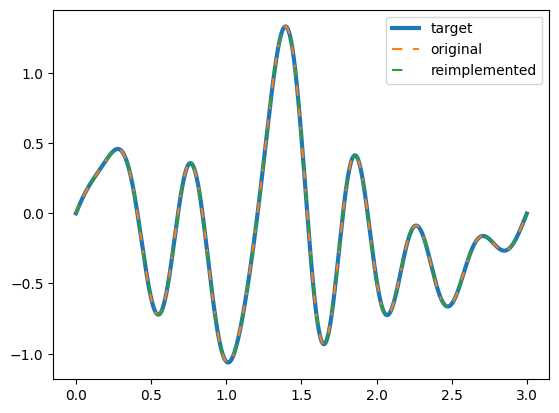

In [36]:
#vals = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(sig[0]):], sig[0], label='target',linewidth=3,)
plt.plot(values[-len(recon[:,-1,0]):], recon[:,-1,0], linestyle='--', label='original', dashes=(5, 5))
plt.plot(values[-len(our_recon[0][-1]):], our_recon[0][-1], linestyle='-', label='reimplemented', dashes=(5, 10))
plt.legend()

In [38]:
print(u.shape)
print(recon.shape)
print(recon_all_t.shape)
print(our_recon.shape)

print(our_recon[0][-1].shape)
print(recon[:,-1,0].shape)

(1, 3000)
torch.Size([3000, 3000, 1])
torch.Size([1, 3000, 3000, 1])
(1, 3000, 3000, 1)
(3000, 1)
torch.Size([3000])


# Visualise Hippo reconstruction: 2 batch dimensions

In [120]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(0)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(2,))
sig, recon, recon_all_t, values, cfs = reconstruct(T=3, dt=1e-3, N=64, freq=3.0, vals=vals, u=u)

-------- Input ----------
inputs.T shape: torch.Size([2, 3000])
inputs.T.unsqueeze.unsqueeze shape: torch.Size([3000, 2, 1, 1])
u torch transpose inputs 0 -2: torch.Size([1, 2, 3000, 1])
u mult Bstack[:L]: torch.Size([1, 2, 3000, 64])
Bstack[:L].shape: torch.Size([3000, 64])
u torch transpose inputs 0 -2: torch.Size([3000, 2, 1, 64])
c torch zeros shape: torch.Size([2, 1, 64])
c eq shape: torch.Size([2, 1, 64])
A_stacked[t] shape: torch.Size([64, 64])
Part 1 shape: torch.Size([2, 1, 64])
f shape: torch.Size([2, 1, 1])
B_stacked[t] shape : torch.Size([64])
Part 2 shape: torch.Size([2, 1, 64])
cs stacked shape: torch.Size([3000, 2, 1, 64])
-------- Reconstruction ----------
c shape: torch.Size([3000, 2, 1, 64])
c shape: torch.Size([2, 3000, 1, 64])
c shape: torch.Size([2, 3000, 64, 1])
Recon a shape: torch.Size([2, 3000, 3000, 1])
Eval mat.to(x) shape: torch.Size([3000, 64])
-------- Input ----------
inputs.T shape: torch.Size([2, 3000])
inputs.T.unsqueeze.unsqueeze shape: torch.Size([30

In [122]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(0)
our_hippo = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(2,))
coeffs, our_recon = our_hippo(u)

-------- Input ----------
inputs shape (2, 3000)
inputs.T.unsqueeze.unsqueeze shape torch.Size([3000, 2, 1, 1])
c t zeroes shape (2, 1, 64)
part1 shape: torch.Size([2, 1, 64])
part2  shape: (2, 1, 64)
A stacked  shape: torch.Size([64, 64])
B stacked  shape: (64,)
input [f] shape: torch.Size([2, 1, 1])
Coef  c t shape: torch.Size([2, 1, 64])


/tmp/ipykernel_74/3360152290.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()).shape)
/tmp/ipykernel_74/3360152290.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()


c t stacked shape: (3000, 2, 1, 64)
-------- Reconstruction ----------
c shape: (3000, 2, 1, 64)
B shape: (64, 1)
c shape: (2, 3000, 1, 64)
c shape: (2, 3000, 64, 1)
Eval mat shape: (3000, 64)
B  shape: (64, 1)
Recon a shape: (2, 3000, 3000, 1)


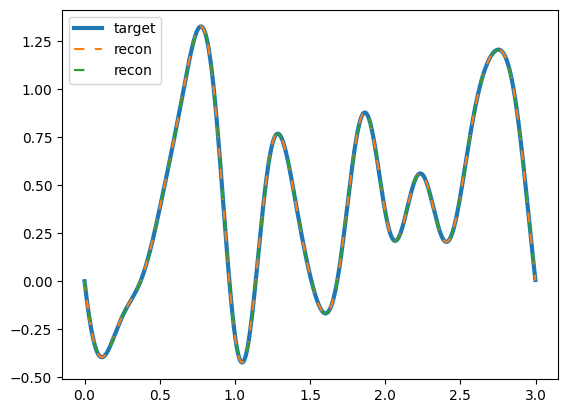

In [124]:
vals = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(sig[0]):], sig[0], label='target',linewidth=3,)
plt.plot(values[-len(recon_all_t[0,:,-1]):], recon_all_t[0,:,-1], linestyle='--', label='', dashes=(5, 5))
plt.plot(values[-len(our_recon[0,-1,:]):], our_recon[0,-1,:], linestyle='--', label='recon', dashes=(5, 10))
plt.legend()

In [71]:
print("Signal shape:", u.shape)
print("Original recon shape:", recon.shape)
print("Original all timeseps recon shape:", recon_all_t.shape)

print("Reimplemented recon shape:", our_recon.shape)


Signal shape: (2, 3000)
Original recon shape: torch.Size([3000, 3000, 1])
Original all timeseps recon shape: torch.Size([2, 3000, 3000, 1])
Reimplemented recon shape: (2, 3000, 3000, 1)


In [85]:
recon_all_t[0]

tensor([[[ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         ...,
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00]],

        [[-3.2014e-10],
         [ 2.4738e-10],
         [ 2.7649e-10],
         ...,
         [-1.3310e-02],
         [-1.3328e-02],
         [-1.3345e-02]],

        [[-1.7972e-09],
         [-9.9317e-10],
         [-1.3861e-09],
         ...,
         [-1.3298e-02],
         [-1.3280e-02],
         [-1.3262e-02]],

        ...,

        [[ 3.3909e-03],
         [-1.5376e-03],
         [-7.1396e-03],
         ...,
         [ 3.0499e-02],
         [ 2.3668e-02],
         [ 1.6903e-02]],

        [[ 3.3919e-03],
         [-1.5395e-03],
         [-7.1439e-03],
         ...,
         [ 2.3653e-02],
         [ 1.6857e-02],
         [ 1.0130e-02]],

        [[ 3.3928e-03],
         [-1.5411e-03],
         [-7.1480e-03],
         ...,
         [ 1.6845e-02],
         [ 1.0086e-02],
         [ 3.3953e-03]]])

In [88]:
our_recon

array([[[[ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[-4.13083567e-09],
         [ 4.20547319e-10],
         [ 1.62440794e-09],
         ...,
         [ 5.09711727e-03],
         [ 5.10392291e-03],
         [ 5.11073787e-03]],

        [[ 2.43256082e-08],
         [ 1.19991554e-08],
         [ 2.40912956e-09],
         ...,
         [ 4.89580538e-03],
         [ 4.88858251e-03],
         [ 4.88132518e-03]],

        ...,

        [[-1.34034513e-03],
         [ 6.16835256e-04],
         [ 2.74585281e-03],
         ...,
         [-1.28886178e-02],
         [-9.82933026e-03],
         [-6.89572562e-03]],

        [[-1.34052918e-03],
         [ 6.17540500e-04],
         [ 2.74745142e-03],
         ...,
         [-9.82258096e-03],
         [-6.87541813e-03],
         [-4.05485695e-03]],

        [[-1.34078064e-03],
         [ 6.18414779e-04],
         [